In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Overview

In this notebook, we are going to explore  two binary linear classification models, concretely  Logistic Regression (LR) and Linear Discriminant Analysis (LDA). The main goals of this notebook are:

- Learn how to use the plug-and-play models implemented in the Python package sklearn.
- Evaluate robustness of both models to data perturbations
- Explore the power of basis functions for linearly non-separable classes
- Evaluate our models. Understand which metrics are (not) suitable for imbalance datasets.

# Datasets

We consider two datasets:
- 2-dimensional isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation.

- 2-dimensional circles.  Samples for each class are generated from circles with a certain radius plus some noise.


In [2]:
from sklearn.datasets import make_circles, make_blobs, make_moons

In [3]:
def plot_dataset(X, y, title, axes=None):
  if axes is None:
    axes = plt.gca()
  y_zero = y==0
  y_one = y==1

  axes.scatter(X[y_zero,0],X[y_zero,1],color = "red", label = "Class 0")
  axes.scatter(X[y_one,0],X[y_one,1], color = "blue", label = "Class 1")
  axes.set_title(title)
  axes.set_xlabel("x1")
  axes.set_ylabel("x2")
  axes.legend()
  #plt.show()

In [4]:
n_samples = 100
X_blobs, y_blobs = make_blobs(n_samples=n_samples, centers=[(-1, -1), (1, 1)], cluster_std = 0.5)
X_circles, y_circles = make_circles(n_samples=n_samples,factor=.25, noise=.05)

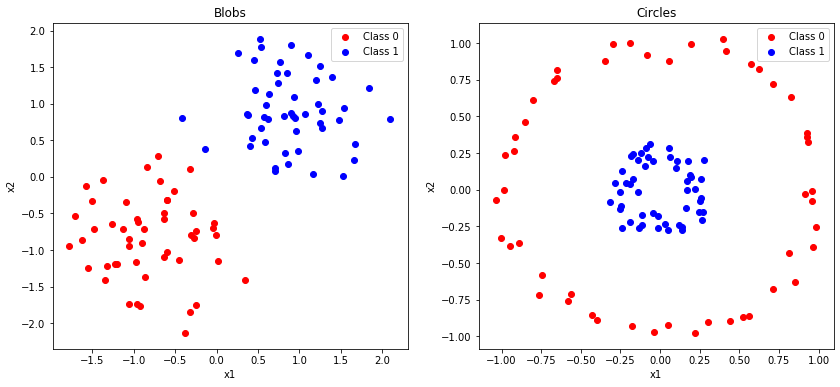

In [5]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plot_dataset(X_blobs, y_blobs, title="Blobs", axes = ax[0])
plot_dataset(X_circles, y_circles, title="Circles", axes = ax[1])

# Binary linear Classification
 Let us assume  we have access to $n$ i.i.d. training samples $D_n = (\mathbf{x}_i, y_i)_{i=1}^n$, with $\mathbf{x}_i \in \mathbb{R}^d$. Throughout this notebook, we are going to focus on the **binary linear classification setting:**

 - The **binary** part implies that our output (a.k.a. target or label) takes values $ y_i = \{-1,+1\}$.
 - The **linear** part implies we consider a family of functions $f \in \mathcal{F}$ that are linear, i.e. $\mathcal{F} = \left\{\langle\mathbf{w}, \mathbf{x}\rangle+b, \text { with } \mathbf{x}, \mathbf{w} \in \mathbb{R}^{d}, b \in \mathbb{R}\right\}$. In particular, we consider the output (prediction) of our classifier is 

 $$
 \hat{y}(\mathbf{x})=\operatorname{sign}(f(\mathbf{x}))=\operatorname{sign}(\langle\mathbf{w}, \mathbf{x}\rangle+b)=\left\{\begin{array}{ll}1 & \text { if }\langle\mathbf{w}, \mathbf{x}\rangle+b>0 \\ -1 & \text { if }\langle\mathbf{w}, \mathbf{x}\rangle+b \leq 0\end{array}\right.
 $$




 We refer to **decision boundary**  of the classifier $ \hat{y}(\mathbf{x}) = \operatorname{sign}(f(\mathbf{x}))$ to the set of points in the input spaces such that the output of $f(\mathbf{x})$ is zero, i.e. $\{\mathbf{x} \in \mathcal{X} \mid f(\mathbf{x})=0\}.$ Basically, the decision boundary separates the input space $\mathbb{R}^d$ into two half spaces.



**Remark.** As with linear regression, we could also apply basis functions to map the input features $\mathbf{x}_i \in \mathbb{R}^d$ into a possibly larger feature space $\mathbb{R}^D$, i.e. $\mathbf{x} \in \mathbb{R}^{d} \longrightarrow\left(\phi_{1}(\mathbf{x}), \ldots, \phi_{D}(\mathbf{x})\right).$

## Logistic Regression (LR)
Logitic regression is a supervised algorithm that models the conditional likelihood  $p(y | \mathbf{x})$ using a sigmoid function

\begin{align}
p=\mathrm{P}(Y=1 \mid X=\mathbf{x}, \mathbf{w}, b)=\frac{1}{1+e^{-\langle\mathbf{w}, \phi(\mathbf{x})\rangle + b }},
\end{align}

and finds the model parameters using Maximum Likelihood Estimation (MLE):

\begin{align}
\mathbf{w}^* & = \underset{\mathbf{w}}{\arg \max } \prod_{i=1}^{n} \mathrm{P}\left(Y=y_{i} \mid X=\mathbf{x}_{i}, \mathbf{w}\right)\\
& = \underset{\mathbf{w}}{\arg \max } \sum_{i=1}^{n} \log \mathrm{P}\left(Y=y_{i} \mid X=\mathbf{x}_{i}, \mathbf{w}\right)\\
& = \underset{\mathbf{w}}{\arg \min } \sum_{i=1}^{n} \log \left( 1+e^{-\langle\mathbf{w}, \phi(\mathbf{x})\rangle} \right)
\end{align}

## Linear Discriminant Analysis (LDA)
Linear Discriminant Analysis is a supervised algorithm that assumes our data $\mathbf{x}$ comes from an isometric Gaussian distribution. LDA models the distribution $p(\mathbf{x} | y)$. Then, it tries to find the linear projection $\mathbf{w}$ that i) maximizes the distance between the means of the two classes, and ii) minimizes the variance within each class. It does so by maximizing the Fisher criterion:

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \max } J(\mathbf{w}) = \underset{\mathbf{w}}{\arg \max } \frac{\left\langle\mathbf{w}, m_{+}-m_{-}\right\rangle^{2}}{\sigma_{\mathbf{w},+}^{2}+\sigma_{\mathbf{w},-}^{2}}.
$$

To maximize the Fisher criterion we need to:

1. Compute the $d$-dimensional class centroids (a.k.a. means):
$$
m_{+}=\frac{1}{n_{+}} \sum_{\left\{i \mid Y_{i}=1\right\}} X_{i}, \quad m_{-}=\frac{1}{n_{-}} \sum_{\left\{i \mid Y_{i}=-1\right\}} X_{i}
$$

2. Compute the within-class covariances of th projections of the positive and negative class:

$$
\sigma_{\mathbf{w},+}^{2}=\sum_{\left\{i \mid Y_{i}=1\right\}}\left(\left\langle\mathbf{w}, X_{i}\right\rangle-\left\langle\mathbf{w}, m_{+}\right\rangle\right)^{2}, \sigma_{\mathbf{w},-}^{2}=\sum_{\left\{i \mid Y_{i}=-1\right\}}\left(\left\langle\mathbf{w}, X_{i}\right\rangle-\left\langle\mathbf{w}, m_{-}\right\rangle\right)^{2}
$$


# Performance Metrics

In order to determine the quality of a classifier $\hat{y}: \mathcal{X} \rightarrow \{-1,1\}$ on a dataset $D_n = (\mathbf{x}_i, y_i)_{i=1}^n$, the following
metrics are commonly used.


\begin{align}
 &TP = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=1 \; \wedge \; y_i=1} && \quad FN = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=-1 \; \wedge \; y_i=1}\\
 &FP = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=1 \; \wedge \; y_i=-1} && \quad TN = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=-1 \; \wedge \; y_i=-1}
\end{align}

**Accuracy** measures the percentage of observations that are correctly classified.
  $$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} = \frac{1}{n}\sum_{i=1}^n \mathbb{1}_{f(x_i)=y_i}$$

**Precision** measures how many predictions out of all positive predictions (i.e. TP+FP) are positive observations.
                $$ Precision = \frac{TP}{TP+FP} $$

**Recall** measures how many observations out of all positive observations (i.e.TP+FN) have we classified as positive.
                $$ Recall = \frac{TP}{TP+FN} $$
**False Positive Rate (FPR)** measures how many observations out of all negative observations (i.e.,N=FP+TN) have we classified as positive.
$$FPR = \frac{FP}{FP+TN} $$

**F1-score** is the harmonic mean of Precision + Recall.  It combines the two measures into one.Why do not just use the simple mean? Well, simply because the harmonic mean punishes extreme values.
                $$ F1\text{-}Score = 2 \cdot \frac{Precision \cdot Recall }{Precision + Recall } $$


**ROC curve** plots the Recall versus the false positive rate (FPR) by varying the discrimination threshold $\theta \in [0,1]$.

**PR curve** lots precision (PPV) versus the recall (TPR) by varying the discrimination threshold $\theta \in [0,1]$.


For more information check: https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda-math


# Robustness to data perturbations

Analyze how do the decision boundaries of the two algorithms under study change when we add a second Gaussian blob.

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Decision Boundry LDA
The decision boundry for LDA is given by:
$$ \{x \in \mathbb{R}^d |  \langle\mathbf{w}, \mathbf{x}\rangle+b = 0\}$$

In order to determine a point on the decision boundry we can fix the first $d-1$ coordinates for $x \in \mathbb{R}^d$ and then solve for $x_d$.
\begin{align}
 \langle\mathbf{w}, \mathbf{x}\rangle+b &= 0 \\
 \Leftrightarrow  \sum_{i=1}^d w_ix_i +b&= 0 \\
 \Leftrightarrow \qquad \quad \,\,\, x_d &= -\frac{\sum_{i=1}^{d-1} w_ix_i + b}{w_d}
\end{align}


## Decision Boundry Logistic Regression

The descicion boundry for the logistic regression are all points, which satisfiy the following equation:
\begin{align} 
p=\mathrm{P}(Y=1 \mid X=\mathbf{x}, \mathbf{w})=\frac{1}{1+e^{-(\langle\mathbf{w}, \mathbf{x}\rangle+b)}} = \frac{1}{2}
\end{align} 
This is equivalent to: 
$$ e^{-(\langle\mathbf{w}, \mathbf{x}\rangle+b)} = 1$$
Applying the $ln$ on both sides and multiplying by $-1$ yields:
$$\langle\mathbf{w}, \mathbf{x}\rangle+b = 0 $$
Now, we can proceed exactly as for the LDA.

In [7]:
def compute_lda_descicion_boundry(coef, intercept, x1, x2):
    w1, w2 = coef
    y1 = (-intercept-w1*x1) / w2
    y2 = (-intercept-w1*x2) / w2
    return [[x1,x2],[y1,y2]]
def compute_lr_descicion_boundry(coef, intercept, x1, x2):
      w1, w2 = coef
      y1 = -(w1/w2)*x1 - intercept/w2
      y2 = -(w1/w2)*x2 - intercept/w2
      return [[x1,x2],[y1,y2]]

Accuracy LDA = 1.00
Accuracy LR = 1.00


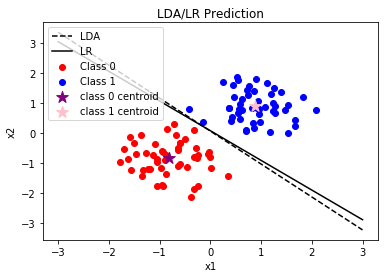

In [8]:
lda = LinearDiscriminantAnalysis().fit(X_blobs,y_blobs)
lda_pred  = lda.predict(X_blobs)
print(f'Accuracy LDA = {accuracy_score(y_blobs, lda_pred):.2f}')

logistic_regression = LogisticRegression().fit(X_blobs,y_blobs)
logistic_regression_pred = logistic_regression.predict(X_blobs)
print(f'Accuracy LR = {accuracy_score(y_blobs, logistic_regression_pred):.2f}')

fig, axes = plt.subplots(1,1,figsize=(6,4))
axes.plot(*compute_lda_descicion_boundry(lda.coef_[0], lda.intercept_, -3,3), color="black", linestyle='dashed', label= "LDA")
axes.plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3,3), color="black", label= "LR")
plot_dataset(X_blobs, lda_pred, title="LDA/LR Prediction", axes = axes)
plt.scatter(*X_blobs[y_blobs==0].mean(0), color='purple', marker="*", s=150, label="class 0 centroid")
plt.scatter(*X_blobs[y_blobs==1].mean(0), color='pink', marker="*", s=150, label="class 1 centroid")
plt.legend()

In [9]:
print(f'class centroids= {X_blobs[y_blobs==0].mean(0)} {X_blobs[y_blobs==1].mean(0)}')

class centroids= [-0.81411467 -0.83724313] [0.88756016 0.89916094]


In [10]:
print('Logistic Regression')
print(f'[w0, w1]= {logistic_regression.coef_[0]}')
print(f'b= {logistic_regression.intercept_[0]}')
print('\nLinear Discriminant Analysis')
print(f'[w0, w1]= {lda.coef_[0]}')
print(f'b= {lda.intercept_[0]}')
print(f'[w0, w1]= {lda.coef_[0]}')
print(f'class centroids= {lda.means_[0]} {lda.means_[1]}')


Logistic Regression
[w0, w1]= [2.25622173 2.28227975]
b= -0.1908368374734457

Linear Discriminant Analysis
[w0, w1]= [7.5991988  6.92218345]
b= -0.4933666572429223
[w0, w1]= [7.5991988  6.92218345]
class centroids= [-0.81411467 -0.83724313] [0.88756016 0.89916094]


Now, we will add a second blob to the positive class. How do the decision boundaries change? Which algorithm is more robust to outliers?

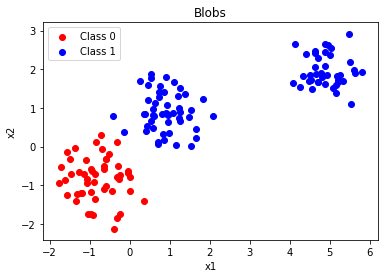

In [11]:
mean = [5, 2]
cov = [[0.2, 0], [0, 0.2]]
num = 40
outlier = np.random.multivariate_normal(mean, cov, num)

X_plobs_outlier = np.concatenate((X_blobs,outlier))
y_blobs_outlier = np.concatenate((y_blobs,np.ones(outlier.shape[0])))
plot_dataset(X_plobs_outlier, y_blobs_outlier, title="Blobs")

In [12]:
lda = LinearDiscriminantAnalysis().fit(X_plobs_outlier,y_blobs_outlier) # Train Linear Discriminant Analysis (LDA)
lda_pred  = lda.predict(X_plobs_outlier)

print(f'Accuracy LDA = {accuracy_score(y_blobs_outlier, lda_pred):.2f}')

logistic_regression = LogisticRegression().fit(X_plobs_outlier,y_blobs_outlier) # Train Logistic Regression (LR)
logistic_regression_pred = logistic_regression.predict(X_plobs_outlier)
print(f'Accuracy LR = {accuracy_score(y_blobs_outlier, logistic_regression_pred):.2f}')


Accuracy LDA = 0.96
Accuracy LR = 1.00


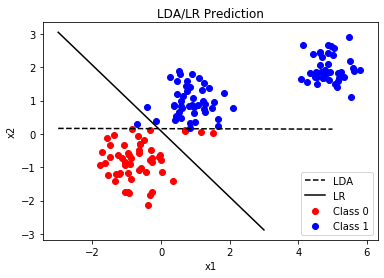

In [13]:
fig, axes = plt.subplots(1,1,figsize=(6,4))
axes.plot(*compute_lda_descicion_boundry(lda.coef_[0], lda.intercept_, -3,5), color="black", linestyle='dashed', label= "LDA")
axes.plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3,3), color="black", label= "LR")
plot_dataset(X_plobs_outlier, lda_pred, title="LDA/LR Prediction", axes = axes)


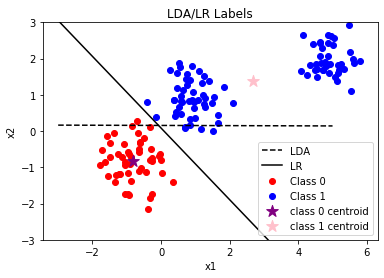

In [14]:
fig, axes = plt.subplots(1,1,figsize=(6,4))
axes.set_ylim(-3,3)
axes.set_ylim(-3,3)
axes.plot(*compute_lda_descicion_boundry(lda.coef_[0], lda.intercept_, -3,5), color="black", linestyle='dashed', label= "LDA")

axes.plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3,5), color="black", label= "LR")
plot_dataset(X_plobs_outlier, y_blobs_outlier, title="LDA/LR Labels", axes = axes)
plt.scatter(*X_plobs_outlier[y_blobs_outlier==0].mean(0), color='purple', marker="*", s=150, label="class 0 centroid")
plt.scatter(*X_plobs_outlier[y_blobs_outlier==1].mean(0), color='pink', marker="*", s=150, label="class 1 centroid")
plt.legend()

In [15]:
print('Logistic Regression')
print(f'[w0, w1]= {logistic_regression.coef_[0]}')
print(f'b= {logistic_regression.intercept_[0]}')
print('\nLinear Discriminant Analysis')
print(f'[w0, w1]= {lda.coef_[0]}')
print(f'b= {lda.intercept_[0]}')
print(f'[w0, w1]= {lda.coef_[0]}')
print(f'class centroids= {lda.means_[0]} {lda.means_[1]}')


Logistic Regression
[w0, w1]= [2.25625052 2.28228461]
b= -0.1908295782529881

Linear Discriminant Analysis
[w0, w1]= [0.01419235 5.15943954]
b= -0.8042091492803534
[w0, w1]= [0.01419235 5.15943954]
class centroids= [-0.81411467 -0.83724313] [2.67190518 1.37172468]


**Question.** Looking at the decision boundary obtained...What is happening in the LDA optimization? 

> a) LDA maximizes the distance between the means of the two classes.

> b) LDA minimizes the variance within each class.

From now on, we will focus on the Logistic Regression classifier.


# Introducing basis functions


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, accuracy_score

First, we fit a Logistic Regression model on vanilla linear features.

Accuracy=0.51


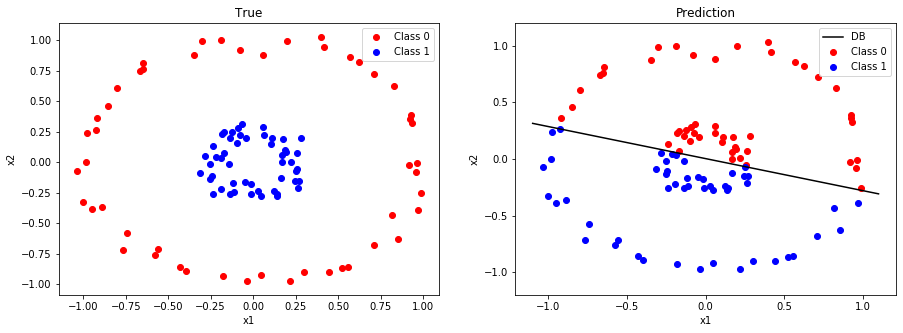

In [17]:
logistic_regression = LogisticRegression().fit(X_circles,y_circles)
logistic_regression_pred = logistic_regression.predict(X_circles)

print(f'Accuracy={accuracy_score(y_circles, logistic_regression_pred):.2f}')
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_dataset(X_circles, y_circles, title="True", axes=ax[0])
ax[1].plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -1.1,1.1), color="black", label= "DB")
ax[1].set_ylim(-1.2,1.2)
plot_dataset(X_circles, logistic_regression_pred, title="Prediction",axes=ax[1])

Clearly, the data is not linearly seperable. Now, there are two possibilities to tackle this problem. One could use a non-linear classifier, that has sufficient capacity to model such a descicion boundry. Or, one could transform the data, such that it becomes linearly seperable. This is also the approach presented in the following: <br>

We use the transformation:
$$ \phi:\mathbb{R}^2 \rightarrow \mathbb{R}^3, \; (x_1,x_2)^T \mapsto (x_1,x_2,x_1^2 + x_2^2)^T $$

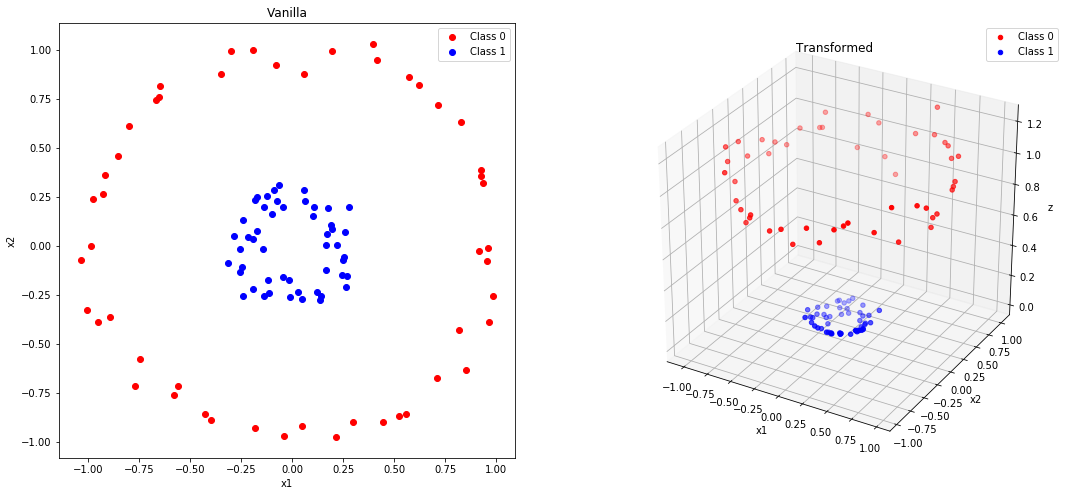

In [18]:
from mpl_toolkits.mplot3d import Axes3D


t = lambda x,y:  (np.square(x) + np.square(y)).reshape(-1,1) 
X_t = t(X_circles[:,0], X_circles[:,1])
X_transformed = np.concatenate( (X_circles,X_t), axis=1)
red = y_circles == 0
blue = y_circles == 1

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

plot_dataset(X_circles, y_circles, title="Vanilla", axes=ax1)

ax2.scatter3D(X_transformed[red,0], X_transformed[red,1], X_transformed[red,2], color="red", label = "Class 0")
ax2.scatter(X_transformed[blue,0], X_transformed[blue,1], X_transformed[blue,2], color="blue", label = "Class 1")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("z")
ax2.set_title("Transformed")
ax2.legend()
plt.show()

As a next, we fit a LR model on the transformed data and plot the descicion surface.

Accuracy on vanilla data: 0.51
Accuracy on transformed data: 1.00


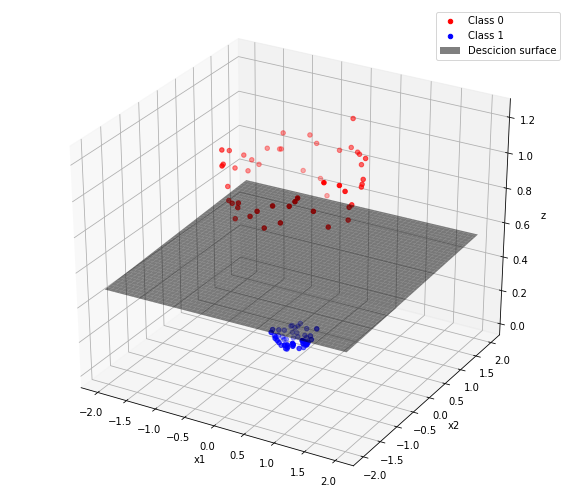

In [19]:

logistic_regression_t = LogisticRegression().fit(X_transformed,y_circles)
logistic_regression_pred_t = logistic_regression_t.predict(X_transformed)
x = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(x, x, )

w1,w2,w3 = logistic_regression_t.coef_[0]
b = logistic_regression_t.intercept_

z = - w2/w3*x2 - w1/w3*x1 - b/w3

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(projection='3d')
red = y_circles == 0
blue = y_circles == 1

ax.scatter(X_transformed[red,0], X_transformed[red,1], X_transformed[red,2], color="red", label = "Class 0")
ax.scatter(X_transformed[blue,0], X_transformed[blue,1], X_transformed[blue,2], color="blue", label = "Class 1")
surf = ax.plot_surface(x1, x2, z, alpha=0.5, color="black", label="Descicion surface")
surf._facecolors2d=surf._facecolors3d # https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf._edgecolors2d=surf._edgecolors3d
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("z")
print(f'Accuracy on vanilla data: {accuracy_score(y_circles, logistic_regression_pred):.2f}')
print(f'Accuracy on transformed data: {accuracy_score(y_circles, logistic_regression_pred_t):.2f}')
ax.legend()
plt.show()

# Exploring evaluation metrics

In the following, we are gonna explore different evaluation metrics


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, accuracy_score

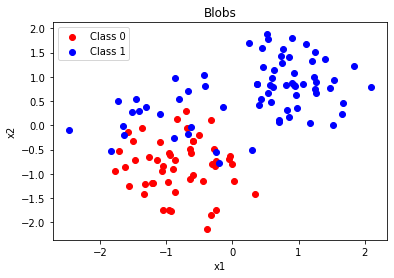

In [21]:
mean = [-1, 0]
cov = [[.3, 0], [0, 0.3]]
num = 20
outlier = np.random.multivariate_normal(mean, cov, num)

X_blobs_2 = np.concatenate((X_blobs,outlier))
y_blobs_2 = np.concatenate((y_blobs,np.ones(outlier.shape[0])))
plot_dataset(X_blobs_2, y_blobs_2, title="Blobs")


Accuracy=0.89


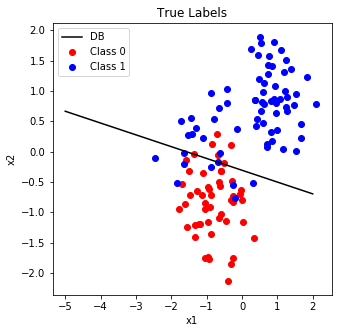

In [22]:
logistic_regression = LogisticRegression().fit(X_blobs_2,y_blobs_2)
logistic_regression_pred = logistic_regression.predict(X_blobs_2)

print(f'Accuracy={accuracy_score(y_blobs_2, logistic_regression_pred):.2f}')
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -5,2.0), color="black", label= "DB")
plot_dataset(X_blobs_2, y_blobs_2, title="True Labels",axes=ax)

 Compare precision/recall/accuracy/F1 score.

In [23]:
print(classification_report(y_blobs_2, logistic_regression_pred, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.85      0.90      0.87        50
     Class 1       0.93      0.89      0.91        70

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



 Plot confusion matrix

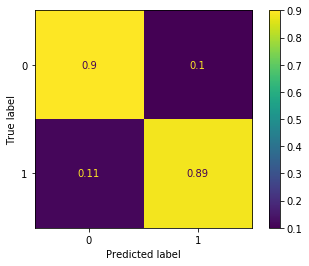

In [24]:
plot_confusion_matrix(logistic_regression, X_blobs_2, y_blobs_2, labels = [0,1], normalize='true')
plt.show()

ROC curve

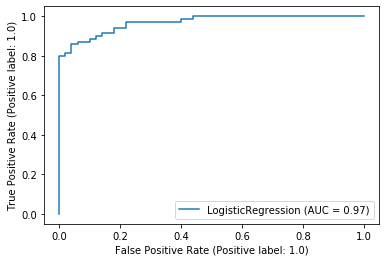

In [25]:
plot_roc_curve(logistic_regression, X_blobs_2, y_blobs_2)
plt.show()

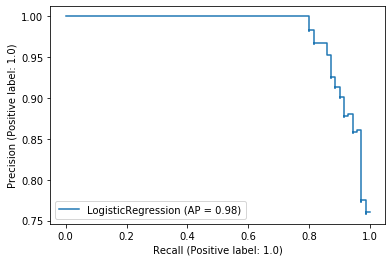

In [26]:
plot_precision_recall_curve(logistic_regression, X_blobs_2, y_blobs_2)
plt.show()

# Binary classification: Unbalanced classes
- Plot the decision boundaries of LR when training with a dataset w/o basis functions with non Linear separable dataset.
- Compare precision/recall/accuracy/F1 score (use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Plot confusion matrix
- ROC curve
- PR curve curve

In [27]:
#make imbalenced blobs
def make_imbalanced_blobs(n_samples):
  X1, y1 = make_blobs(n_samples=2*n_samples[0], centers=[(-1, -1), (1, 1)], cluster_std = 1.5)
  X2, y2 = make_blobs(n_samples=2*n_samples[1], centers=[(-1, -1), (1, 1)], cluster_std = 1.5)
  return np.concatenate((X1[y1==0],X2[y2==1])), np.concatenate((y1[y1==0],y2[y2==1]))

Accuracy=0.86


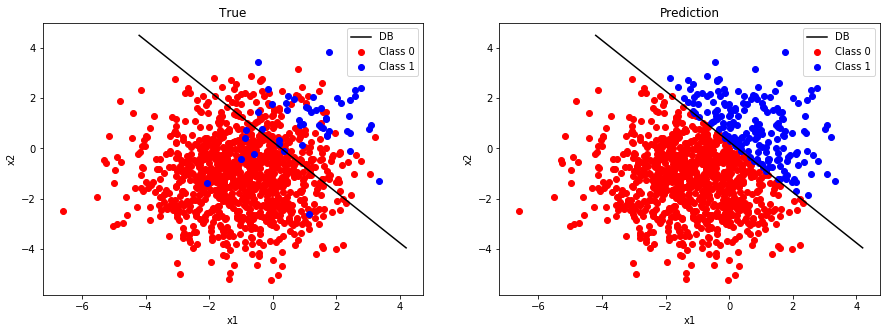

In [28]:

X_blobs_imbalanced, y_blobs_imbalanced = make_imbalanced_blobs([1000,50])
# logistic_regression = LogisticRegression(class_weight=None).fit(X_moons_imbalanced,y_moons_imbalanced)
logistic_regression = LogisticRegression(class_weight={0: 1, 1: 20}).fit(X_blobs_imbalanced,y_blobs_imbalanced)

logistic_regression_pred = logistic_regression.predict(X_blobs_imbalanced)
print(f'Accuracy={accuracy_score(y_blobs_imbalanced, logistic_regression_pred):.2f}')

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -4.2,4.2), color="black", label= "DB")

plot_dataset(X_blobs_imbalanced,y_blobs_imbalanced, title="True", axes=ax[0])
ax[1].plot(*compute_lr_descicion_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -4.2,4.2), color="black", label= "DB")
plot_dataset(X_blobs_imbalanced, logistic_regression_pred, title="Prediction",axes=ax[1])


In [29]:
print(classification_report(y_blobs_imbalanced, logistic_regression_pred, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.99      0.86      0.92      1000
     Class 1       0.23      0.86      0.36        50

    accuracy                           0.86      1050
   macro avg       0.61      0.86      0.64      1050
weighted avg       0.96      0.86      0.89      1050



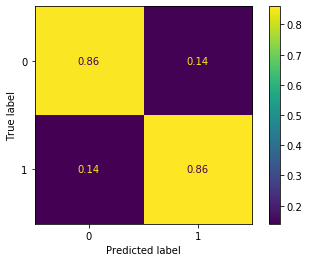

In [30]:
plot_confusion_matrix(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced, labels = [0,1], normalize='true')

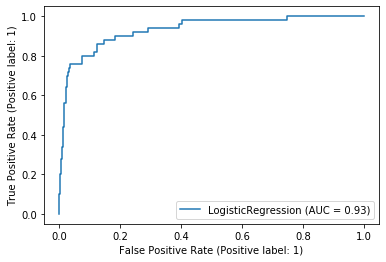

In [31]:
plot_roc_curve(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced)
plt.show()

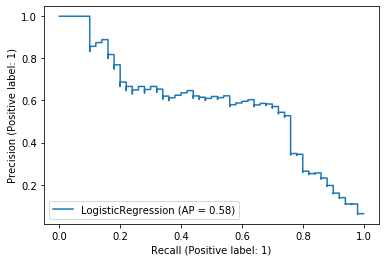

In [32]:
plot_precision_recall_curve(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced)
plt.show()